<table>
    <tr>
        <td>
            <img src="extra/logo-mgu.png" width="150" height="150" />
        </td>
        <td>
        <img src="extra/logo-dep.png" width="150" height="150" />
        </td>
        <td>
            <center>
                <font size = 1>
                2019-2020, MОСКВА, МОСКОВСКИЙ ГОСУДАРСТВЕННЫЙ УНИВЕРСИТЕТ<br>
                ГЕОГРАФИЧЕСКИЙ ФАКУЛЬТЕТ, КАФЕДРА ФИЗИЧЕСКОЙ ГЕОГРАФИИ И ЛАНДШАФТОВЕДЕНИЯ<br><br>
                </font>
                <font size = 3>
                Материалы к работе<br> <b>Отчёт по производственной практике в Баргузинском заповеднике</b><br><br>
                </font>
                <font size = 2>
                <b>Олег Железный</b><br>
                Руководитель ???
                </font>
            </center>
        </td>
    </tr>
</table>


Шапка данного проекта позаимствована у https://github.com/silenteddie/SCGIS_RS_Workshop, за что им большое спасибо.

In [1]:
# импортируем программные библиотеки, которые помогут нам работать со спутниковыми данными

# Основное средство - GDAL. Основной компонент работы с растровыми геоданными, который вообще везде
from osgeo import gdal

# matplotlib - самая большая и мощная библиотека визуализации данных в Python
import matplotlib.pyplot as plt
import matplotlib as mpl

# numpy - одна из главных математических библиотек Python. Быстрые вычисления матриц (а снимки - это матрицы)
import numpy as np

# Некоторые служебные команды. Так мы сможем смотреть на изображения прямо в jupyter notebook
from IPython.display import Image

In [2]:
#loading data
#empty list of variables
reflectances=[]
for i in range (1,13):
    name='B%s' %i
    reflectances.append(name)
    locals()[name] = gdal.Open('Task 1/Ready data/B%s.asc' % i).ReadAsArray()

In [3]:
#loading data
#empty list of variables
radiances=[]
for i in range (1,13):
    name='Rad_B%s' %i
    radiances.append(name)
    locals()[name] = gdal.Open('Task 1/Ready data/Rad_B%s.asc' % i).ReadAsArray()

Не знаю, как работает функция locals, надо почитать... Переводит строку в название аргумента! 

Посмотрим, что у нас в списке:

In [4]:
reflectances

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12']

In [5]:
radiances

['Rad_B1',
 'Rad_B2',
 'Rad_B3',
 'Rad_B4',
 'Rad_B5',
 'Rad_B6',
 'Rad_B7',
 'Rad_B8',
 'Rad_B9',
 'Rad_B10',
 'Rad_B11',
 'Rad_B12']

Уберем все nodata (маску сделаем). Я отключил, потому что сейчас у нас нет nodata.

In [6]:
#for n in reflectances:
    #for a in reflectances:
        #locals()[n][locals()[a] == -99999] = np.nan

In [7]:
#for n in radiances:
    #for a in radiances:
        #locals()[n][locals()[a] == -99999] = np.nan

Размеры наших снимков.

In [8]:
dataset = gdal.Open('Task 1/Ready data/B1.asc')
X=dataset.RasterXSize
Y=dataset.RasterYSize

Сделаем пустой список для файлов с приходящей солнечной радиацией.

In [9]:
irradiances=[]
for i in range (1,13):
    name='Irr%s' %i
    irradiances.append(name)

Основная часть. Сначала разделим значения каналов на 10000, чтобы получить альбедо.

Потом рассчитаем для кадого случая приход радиации.

In [10]:
for i in range (0,12):
    locals()[reflectances[i]]=locals()[reflectances[i]]*0.0001
    locals()[irradiances[i]]=locals()[radiances[i]]/locals()[reflectances[i]]

Что-то в SNAP посчиталось не так. С альбедо всё окей, а вот значения суммарной радиации (как и отражённой) неверны для всех каналов, кроме 2,3,4,8. Поэтому пересчитываем с использованием ESUN для Sentinel. Используется формула $$ radiance = reflectance*cos(incidence angle)*ESUN/(pi*d), $$ где d - квадрат отношения расстояния от солнца до Земли к среднегодовому (поправка на эллипсоидность орбиты), а cos(incidence angle)*ESUN/(pi*distance from sun) и есть Irradiation. Тут меняется только ESUN (W/m^2/nm) в разных диапазонах. 

Кажись, чертов СНАП еще и все снова умножил на 10000. Придется делить... Бесит!

In [11]:
private=Irr2/1959.77/10000 #сначала делим на ESUN и на эти 10000 из СНАПа
Irr1=private*1874.3 #а потом домножаем
Irr5=private*1425.78
Irr6=private*1291.13
Irr7=private*1175.57
Irr9=private*817.58
Irr10=private*365.41
Irr11=private*247.08
Irr12=private*87.75

# тут просто на 10000 разделить
Irr2=Irr2/10000
Irr3=Irr3/10000
Irr4=Irr4/10000
Irr8=Irr8/10000

#восстановим radiances. кстати, те, что я загрузил изначально, всё равно никуда не годятся
# в них есть дырки с nodata. но нам на них плевать:) 
for i in range (0,12):
    locals()[radiances[i]]=locals()[irradiances[i]]*locals()[reflectances[i]]

Теперь найдем суммарный приход радиации. Используем только те каналы Sentinel, которые не соответствуют "дырам". Нужно значение в каждом канале домножить на диапазон канала (как видно, они весьма разные), как бы интегрируя кривую на рис. 
<table>
    <tr>
        <td>
            <img src="extra/Solar_spectrum.png" width="320" height="300" />
        </td>
        <td>
            <img src="extra/Landsat.v.Sentinel.png" width="500" height="300" />
        </td>

In [12]:
# диапазоны:
D1=0.036
D2=0.096
D3=0.045
D4=0.039
D5=0.020
D6=0.018
D7=0.028
D8=0.141
D9=0.027
D10=0.076
D11=0.142
D12=0.240

В данном случае диапазоны в микрометрах (μm), так как irradiance и radiance у нас приведены в kW/(m^2хnm). То есть для перевода в ватты понадобилось бы дклить на 1000, но микрометр - уже 1000 нанометров.

In [13]:
Sum_Irradiation=Irr2*D2+Irr3*D3+Irr4*D4+Irr5*D5+Irr6*D6+Irr7*D7+Irr8*D8+Irr11*D11+Irr12*D12
#Sum_Irradiation=Irr2+Irr3+Irr4+Irr8

И суммарную отраженную радиацию:

In [14]:
Sum_Radiance=Rad_B2*D2+Rad_B3*D3+Rad_B4*D4+Rad_B5*D5+Rad_B6*D6+Rad_B7*D7+Rad_B8*D8+Rad_B11*D11+Rad_B12*D12
#Sum_Radiance=Rad_B2+Rad_B3+Rad_B4+Rad_B8

И наконец, общее альбедо:

In [15]:
Sum_Albedo=Sum_Radiance/Sum_Irradiation

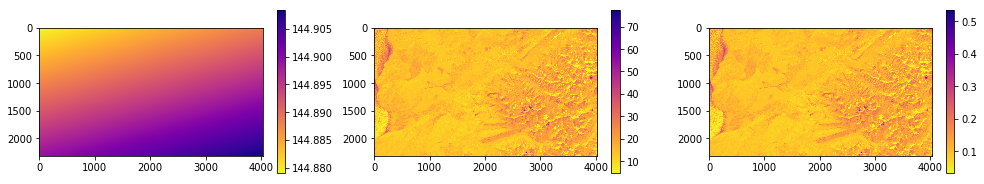

In [16]:
mpl.rcParams['figure.figsize'] = (17,3)

plt.subplot(131)
plt.imshow(Sum_Irradiation, cmap='plasma_r')
plt.colorbar()

plt.subplot(132)
plt.imshow(Sum_Radiance, cmap='plasma_r')
plt.colorbar()

plt.subplot(133)
plt.imshow(Sum_Albedo, cmap='plasma_r')
plt.colorbar()

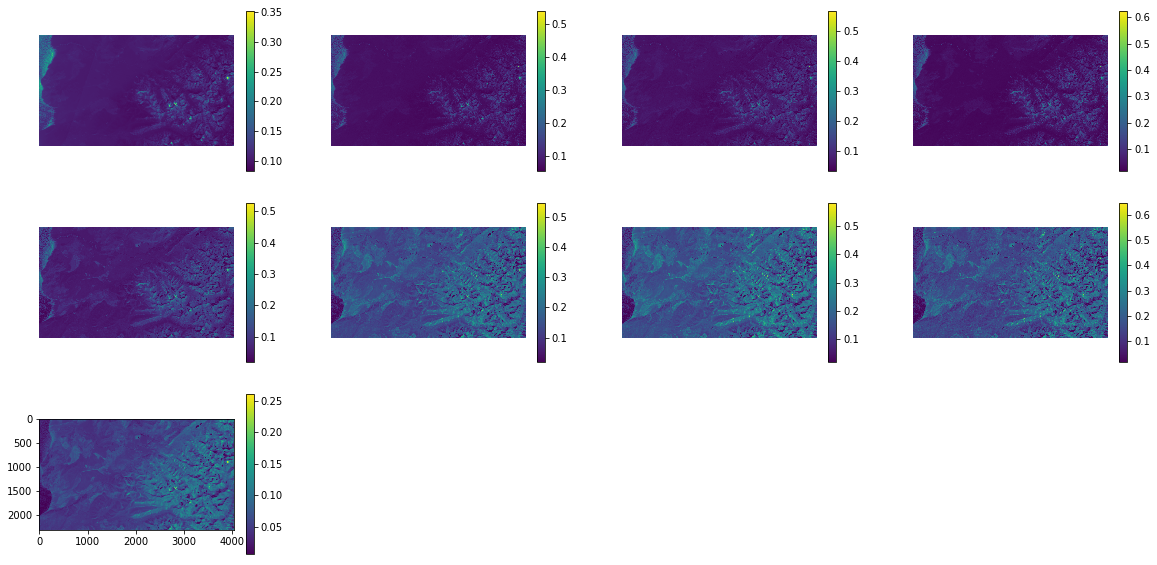

In [17]:
mpl.rcParams['figure.figsize'] = (20,10)
number=341
for n in reflectances:
    plt.subplot(number)
    plt.imshow(locals()[n])
    plt.colorbar()
    number+=1
    if number==350:
        break
    plt.axis('off')
plt.show()

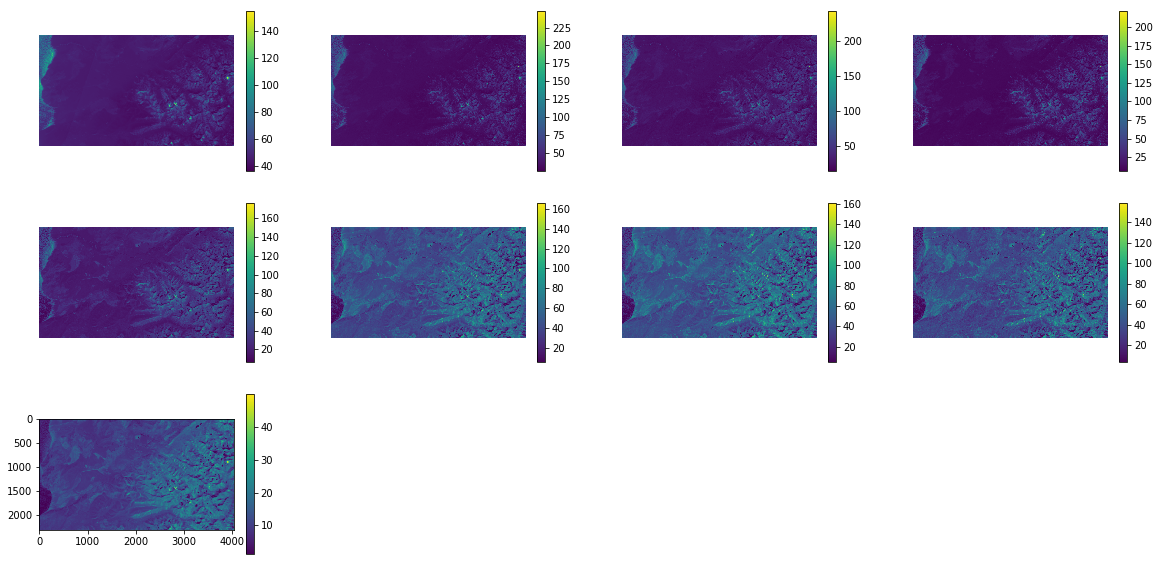

In [18]:
mpl.rcParams['figure.figsize'] = (20,10)
number=341
for n in radiances:
    plt.subplot(number)
    plt.imshow(locals()[n])
    plt.colorbar()
    number+=1
    if number==350:
        break
    plt.axis('off')
plt.show()

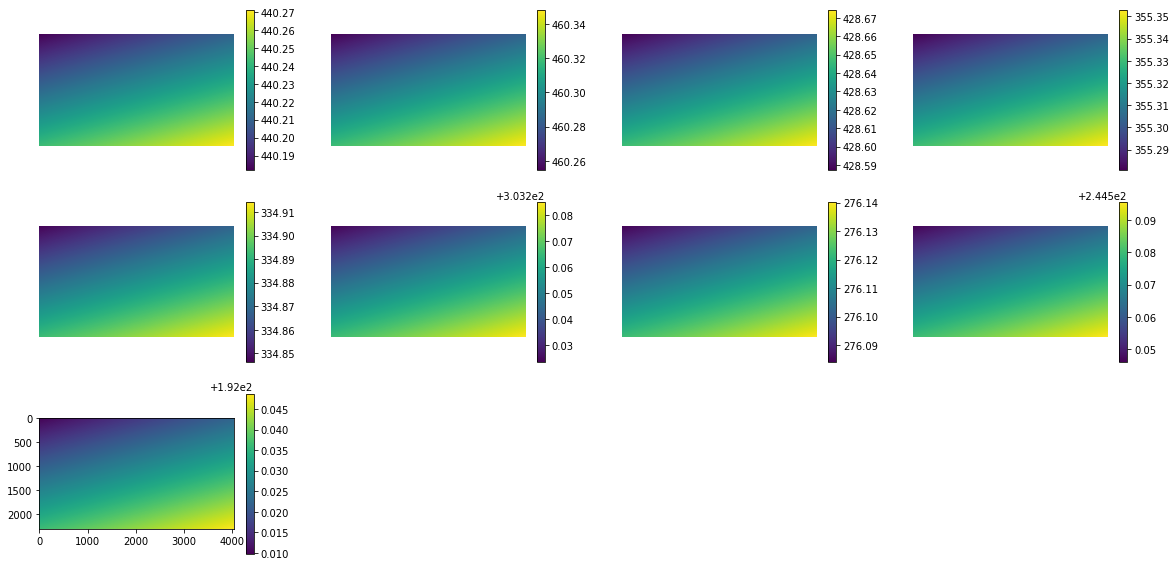

In [19]:
mpl.rcParams['figure.figsize'] = (20,10)
number=341
for n in irradiances:
    plt.subplot(number)
    plt.imshow(locals()[n])
    plt.colorbar()
    number+=1
    if number==350:
        break
    plt.axis('off')
plt.show()

Откроем еще синтезированный снимок. Для этого соберем вместе три снимка.

In [20]:
B2_b = gdal.Open('Task 1/Ready data/B2.asc').ReadAsArray()
B3_g = gdal.Open('Task 1/Ready data/B3.asc').ReadAsArray()
B4_r = gdal.Open('Task 1/Ready data/B4.asc').ReadAsArray()
B8_nir = gdal.Open('Task 1/Ready data/B8.asc').ReadAsArray()

In [21]:
# описываем функцию, которая будет нормализовать значения канала в диапазон от 0 до 1
def normalize(input_band):
    max_value=input_band.max()
    input_band[input_band==-99999] = 123456789.987654321
    min_value=input_band.min()
    input_band[input_band==123456789.987654321] = np.nan
    return ((input_band - min_value)/(max_value - min_value))

# вызываем эту функцию для всех наших трёх каналов
B2_n = normalize(B2_b)
B3_n = normalize(B3_g)
B4_n = normalize(B4_r)
B8_n = normalize(B8_nir)

In [22]:
# дополнительно нормализуем "темные снимки" (но снижается контрастность)
B2_m=(B2_n)**(1/1.9)
B3_m=(B3_n)**(1/2.3)
B4_m=(B4_n)**(1/1.9)
B8_m=(B8_n)**(1/1.7)

Text(0.5,1,'RGB composite image')

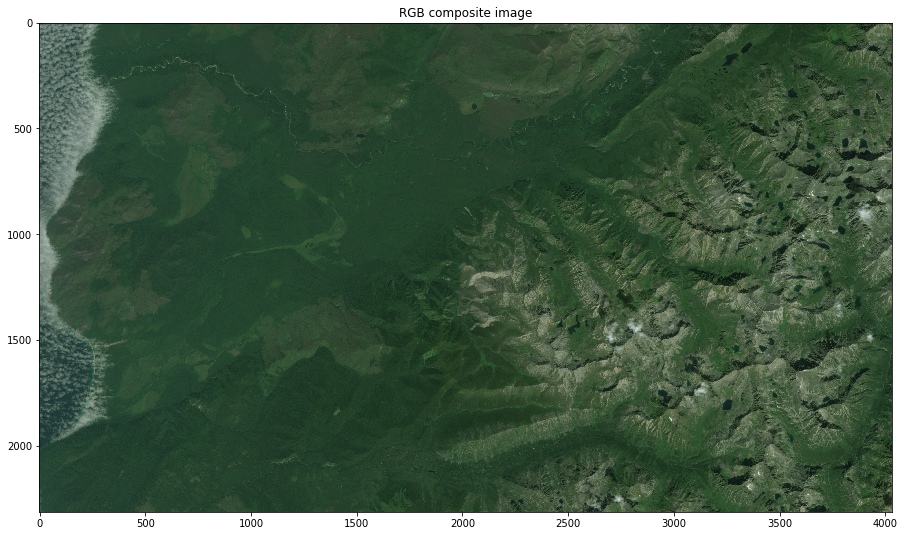

In [23]:
Composite = np.dstack([B4_m,B3_m,B2_m])

mpl.rcParams['figure.figsize'] = (17,9)
plt.imshow(Composite)
plt.title('RGB composite image')

И в псевдоцветах:

Text(0.5,1,'RGB composite image')

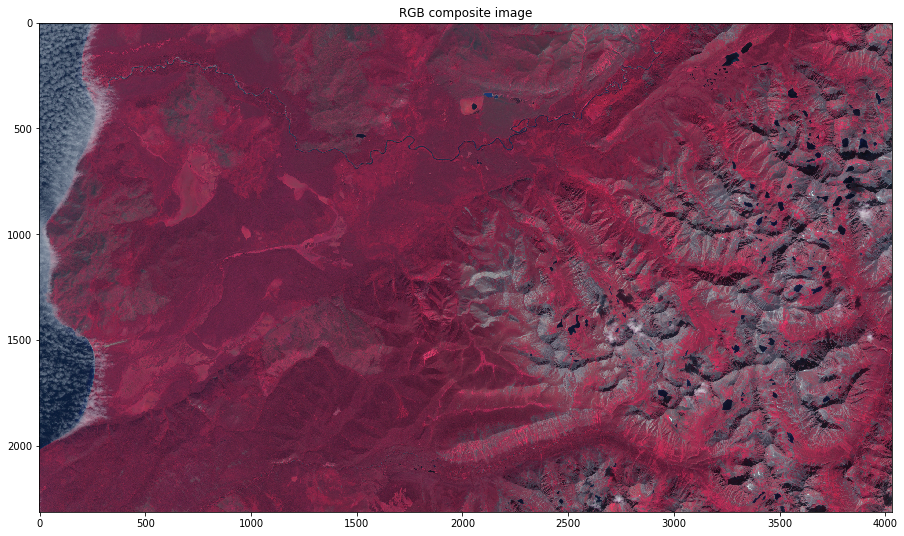

In [24]:
Composite2 = np.dstack([B8_m,B4_m,B3_m])

mpl.rcParams['figure.figsize'] = (17,9)
plt.imshow(Composite2)
plt.title('RGB composite image')

In [25]:
#импорт библиотечки для масштаба
import matplotlib.cbook as cbook
from matplotlib_scalebar.scalebar import ScaleBar

In [26]:
# зададим рисовательную функцию, чтобы 100 раз не писать
def drawer():
    scalebar = ScaleBar(1, units='m', location=4, scale_loc='bottom', length_fraction=0.4, height_fraction=0.007, frameon='True') # 1 pixel = 30 meters
    plt.gca().add_artist(scalebar)
    #настроим подписи координатных осей, чтобы их было не слишком много
    plt.xticks(np.arange(405030, 400030+40330, 10000))
    plt.yticks(np.arange(6016260, 23140+6016260, 10000))
    #повернем подписи и поместим их по центру
    plt.yticks(va='center', rotation=90)

А тепрь красивенько нарисуем.

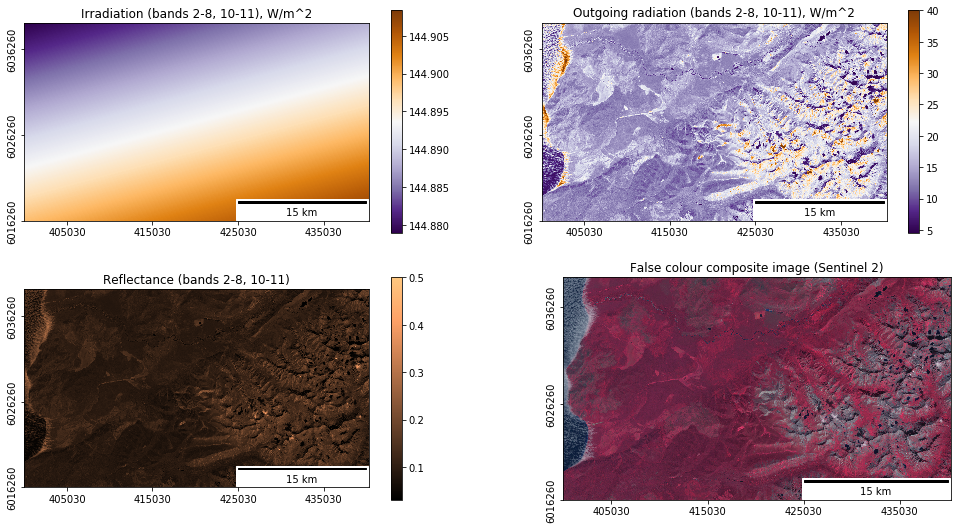

In [34]:
mpl.rcParams['figure.figsize'] = (17,9)

plt.subplot(221)
plt.imshow(Sum_Irradiation, extent=[400030, 400030+40330, 6016260, 23140+6016260], cmap='PuOr_r')
plt.title('Irradiation (bands 2-8, 10-11), W/m^2')
plt.colorbar()
drawer()

plt.subplot(222)
plt.imshow(Sum_Radiance, vmax=40, extent=[400030, 400030+40330, 6016260, 23140+6016260], cmap='PuOr_r')
plt.title('Outgoing radiation (bands 2-8, 10-11), W/m^2')
plt.colorbar()
drawer()

plt.subplot(223)
plt.imshow(Sum_Albedo, vmax=0.5, extent=[400030, 400030+40330, 6016260, 23140+6016260], cmap='copper')
plt.title('Reflectance (bands 2-8, 10-11)')
plt.colorbar()
drawer()

plt.subplot(224)
plt.imshow(Composite2, vmin=-0.5, vmax=0.5, extent=[400030, 400030+40330, 6016260, 23140+6016260])
plt.title('False colour composite image (Sentinel 2)')
drawer()

# сохраним рисунок в хорошем качестве
plt.savefig('report.png', format='png', dpi=250)

И сохраним файлы.

In [28]:
#Sum_Albedo[Sum_Albedo == -99999] = np.nan
#Sum_Radiance[Sum_Radiance == -99999] = np.nan
#Sum_Irradiation[Sum_Irradiation == -99999] = np.nan

In [29]:
Sum_Albedo[np.isnan(Sum_Albedo)] = -99999
Sum_Radiance[np.isnan(Sum_Radiance)] = -99999
Sum_Irradiation[np.isnan(Sum_Irradiation)] = -99999
#got nodata back
np.savetxt('Sum_Albedo.asc', Sum_Albedo, fmt='%4.7f', comments='', header='NCOLS %s \nNROWS %s \nXLLCORNER 400030.0000000000 \nYLLCORNER 6016260.0000000000 \nCELLSIZE 10.000000 \nNODATA_VALUE -99999.0'%(Y, X))
np.savetxt('Sum_Radiance.asc', Sum_Radiance, fmt='%4.7f', comments='', header='NCOLS %s \nNROWS %s \nXLLCORNER 400030.0000000000 \nYLLCORNER 6016260.0000000000 \nCELLSIZE 10.000000 \nNODATA_VALUE -99999.0'%(Y, X))
np.savetxt('Sum_Irradiation.asc', Sum_Irradiation, fmt='%4.7f', comments='', header='NCOLS %s \nNROWS %s \nXLLCORNER 400030.0000000000 \nYLLCORNER 6016260.0000000000 \nCELLSIZE 10.000000 \nNODATA_VALUE -99999.0'%(Y, X))


In [ ]:
#неудачная попытка сохранить сразу в АркГИСовский файл. Какая-то ошибка gdal...
#from osgeo import gdal_array 
#import array
#driver = gdal.GetDriverByName("ESRI Shapefile")
#datatype=gdal.GDT_Float32
#new_dataset = driver.Create('Probability/Predicted1860.asc', dataset.RasterXSize, dataset.RasterYSize, datatype)
#new_dataset.SetProjection(dataset.GetProjection())
#new_dataset.SetGeoTransform(dataset.GetGeoTransform())
#new_dataset.WriteArray(LU)